In [1]:
import pandas as pd
import numpy as np
import pydotplus 
import io
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import misc
import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
#from sklearn.model_selection import CridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

%matplotlib inline

In [2]:
url = 'https://raw.githubusercontent.com/shughestr/PIMS_2020_Real_Estate_data/master/sample_clean.csv'

#https://raw.githubusercontent.com/firasm/PIMS-BCFSA/master/New_Sample_Clean_latest.csv
    
df = pd.read_csv(url, error_bad_lines=False)
df=df.dropna()
# in this step, we removed 2 columns 
for col in df.columns:
    if len(df[col].unique())==1:
        df.drop(col,inplace=True,axis=1)
  

In [3]:
type(df)

pandas.core.frame.DataFrame

In [4]:
df.describe()


,ASSESSED_VALUE,LATITUDE,LONGITUDE,ROLL_NUMBER,Year,pct_change,YEAR_OF_CONSTRUCTION,saf1,saf2,saf3,...,inc2,inc3,inc4,own1,own2,own3,own4,lab1,lab2,lab3
count,1.529900e+04,15299.000000,15299.000000,1.529900e+04,15299.000000,15299.000000,15299.000000,15299.000000,15299.000000,15299.000000,...,15299.000000,15299.000000,15299.000000,15299.000000,15299.000000,15299.000000,15299.000000,15299.000000,15299.000000,15299.000000
mean,4.523004e+05,51.044774,-114.079116,1.620781e+08,2018.476306,-0.017837,1982.097719,106.809399,130.776325,82.116086,...,29247.783842,43722.751552,97130.447349,63.306497,16.469586,9.336610,0.712607,72.089679,9.703098,0.255145
std,3.584834e+05,0.074284,0.081449,1.699462e+08,1.117147,0.061942,18.441249,96.890371,122.342968,50.463169,...,11550.226079,6801.840770,20128.584981,9.575663,3.173984,4.635557,0.143195,3.760563,1.033558,0.037996
min,0.000000e+00,50.878051,-114.268044,4.017208e+06,2017.000000,-1.000000,1905.000000,7.000000,6.000000,5.000000,...,5805.000000,30445.000000,66906.000000,46.500000,11.000000,0.000000,0.279715,66.100000,7.300000,0.155717
25%,3.077500e+05,50.990644,-114.136302,5.720901e+07,2017.000000,-0.048556,1972.000000,51.000000,60.000000,41.000000,...,20825.000000,40936.000000,78538.000000,55.500000,14.400000,6.900000,0.614027,68.700000,9.000000,0.231198
50%,4.060000e+05,51.053371,-114.082223,1.120925e+08,2018.000000,-0.021841,1981.000000,71.000000,99.000000,75.000000,...,28850.000000,43467.000000,93829.000000,63.300000,15.600000,8.800000,0.749317,71.400000,10.000000,0.263215
75%,5.285000e+05,51.106223,-114.018736,2.001100e+08,2019.000000,0.004292,1998.000000,127.000000,150.000000,115.000000,...,38350.000000,46204.000000,109414.000000,68.200000,18.600000,10.600000,0.830119,74.900000,10.300000,0.284322
max,8.490000e+06,51.175721,-113.923311,7.920388e+08,2020.000000,2.535725,2019.000000,421.000000,780.000000,259.000000,...,50000.000000,59829.000000,147903.000000,91.800000,26.200000,26.500000,0.934105,82.800000,11.300000,0.319590


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15299 entries, 0 to 15999
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ADDRESS               15299 non-null  object 
 1   ASSESSED_VALUE        15299 non-null  float64
 2   COMM_CODE             15299 non-null  object 
 3   COMM_NAME             15299 non-null  object 
 4   LATITUDE              15299 non-null  float64
 5   LONGITUDE             15299 non-null  float64
 6   ROLL_NUMBER           15299 non-null  int64  
 7   Year                  15299 non-null  int64  
 8   location              15299 non-null  object 
 9   fsa                   15299 non-null  object 
 10  pct_change            15299 non-null  float64
 11  YEAR_OF_CONSTRUCTION  15299 non-null  float64
 12  saf1                  15299 non-null  float64
 13  saf2                  15299 non-null  float64
 14  saf3                  15299 non-null  float64
 15  saf4               

In [6]:
from itertools import product

def check_cardinality(df):

    combinations_lst = list(product(df.columns, df.columns))
    relations = ['one_to_one', 'one_to_many', 'many_to_one']

    output = []
    for col1, col2 in combinations_lst:
        for relation in relations:
            try:
                pd.merge(df[[col1]], df[[col2]], left_on=col1, right_on=col2, validate=relation)
                output.append([col1, col2, relation])
            except:
                continue

    return output



In [7]:
def get_relation(df, col1, col2):        
    first_max = df[[col1, col2]].groupby(col1).count().max()[0]
    second_max = df[[col1, col2]].groupby(col2).count().max()[0]
    if first_max==1:
        if second_max==1:
            return 'one-to-one'
        else:
            return 'one-to-many'
    else:
        if second_max==1:
            return 'many-to-one'
        else:
            return 'many-to-many'

from itertools import product
for col_i, col_j in product(df.columns, df.columns):
    if col_i == col_j:
        continue
    print(col_i, col_j, get_relation(df, col_i, col_j))

ADDRESS ASSESSED_VALUE many-to-many
ADDRESS COMM_CODE many-to-many
ADDRESS COMM_NAME many-to-many
ADDRESS LATITUDE many-to-many
ADDRESS LONGITUDE many-to-many
ADDRESS ROLL_NUMBER many-to-many
ADDRESS Year many-to-many
ADDRESS location many-to-many
ADDRESS fsa many-to-many
ADDRESS pct_change many-to-many
ADDRESS YEAR_OF_CONSTRUCTION many-to-many
ADDRESS saf1 many-to-many
ADDRESS saf2 many-to-many
ADDRESS saf3 many-to-many
ADDRESS saf4 many-to-many
ADDRESS saf5 many-to-many
ADDRESS saf6 many-to-many
ADDRESS saf7 many-to-many
ADDRESS saf8 many-to-many
ADDRESS mr5y many-to-many
ADDRESS Inflation many-to-many
ADDRESS pop1 many-to-many
ADDRESS pop2 many-to-many
ADDRESS pop3 many-to-many
ADDRESS pop4 many-to-many
ADDRESS pop5 many-to-many
ADDRESS pop6 many-to-many
ADDRESS lan1 many-to-many
ADDRESS lan2 many-to-many
ADDRESS inc1 many-to-many
ADDRESS inc2 many-to-many
ADDRESS inc3 many-to-many
ADDRESS inc4 many-to-many
ADDRESS own1 many-to-many
ADDRESS own2 many-to-many
ADDRESS own3 many-to-man

In [8]:
df['y_bin']=pd.cut(df['pct_change'], bins=np.linspace(df['pct_change'].quantile(0.01), df['pct_change'].quantile(0.99), 11),labels=range(0,10))
df_tree=df.dropna()
train, test= train_test_split(df_tree, test_size=0.2)

In [9]:
#df['y_bin'].value_counts()
#df['y_bin'].hist()

#df['y_bin']

#df['y_bin'].isnull().sum()

#df['pct_change'].hist()
#df['y_bin'][df['y_bin'].isnull()]
#df_tree['y_bin'][df_tree['y_bin'].isnull()]
np.linspace(-0.5, 0.5, 21)

array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
       -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
        0.4 ,  0.45,  0.5 ])

In [10]:
print("Training size:{}; Test size: {}".format(len(train),len(test)))

Training size:11994; Test size: 2999


In [11]:
train.shape

(11994, 42)

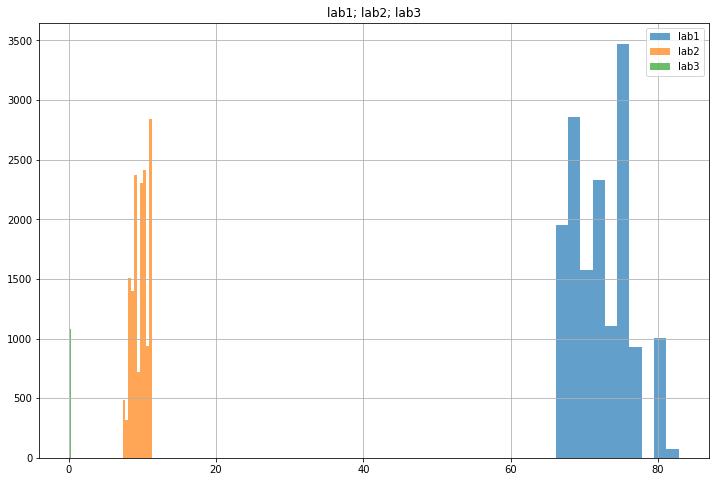

In [12]:
fig=plt.figure(figsize=(12,8))
plt.title("lab1; lab2; lab3")
df['lab1'].hist(alpha=0.7,label='lab1')
df['lab2'].hist(alpha=0.7,label='lab2')
df['lab3'].hist(alpha=0.7,label='lab3')
plt.legend(loc="upper right")

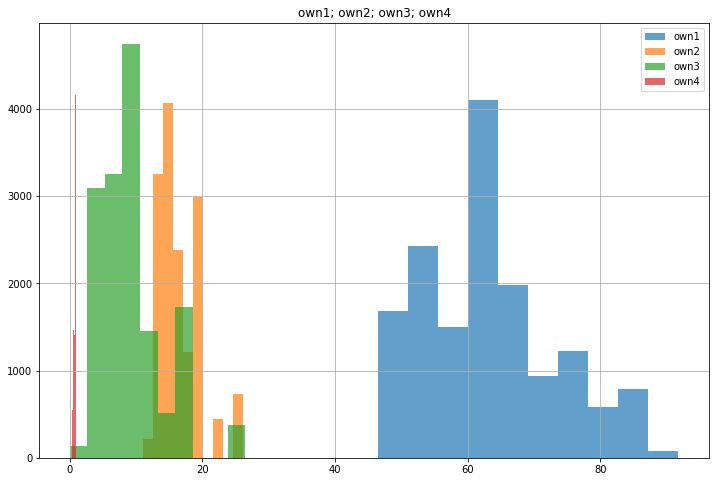

In [13]:
fig=plt.figure(figsize=(12,8))
plt.title("own1; own2; own3; own4")
df['own1'].hist(alpha=0.7,label='own1')
df['own2'].hist(alpha=0.7,label='own2')
df['own3'].hist(alpha=0.7,label='own3')
df['own4'].hist(alpha=0.7,label='own4')
plt.legend(loc="upper right")

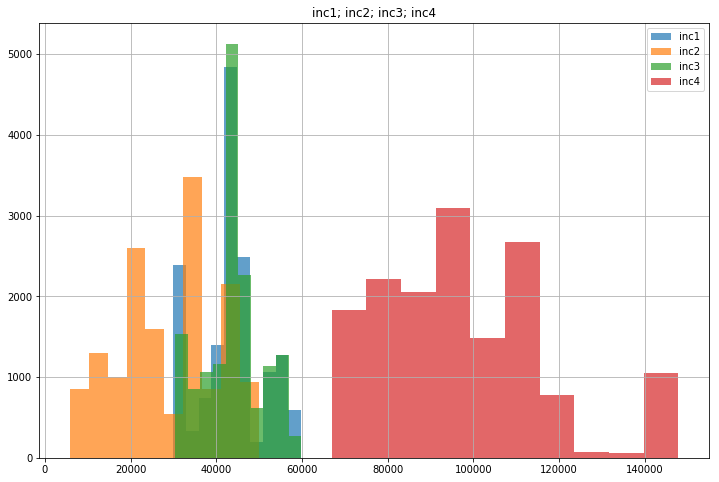

In [14]:
fig=plt.figure(figsize=(12,8))
plt.title("inc1; inc2; inc3; inc4")
df['inc1'].hist(alpha=0.7,label='inc1')
df['inc2'].hist(alpha=0.7,label='inc2')
df['inc3'].hist(alpha=0.7,label='inc3')
df['inc4'].hist(alpha=0.7,label='inc4')
plt.legend(loc="upper right")

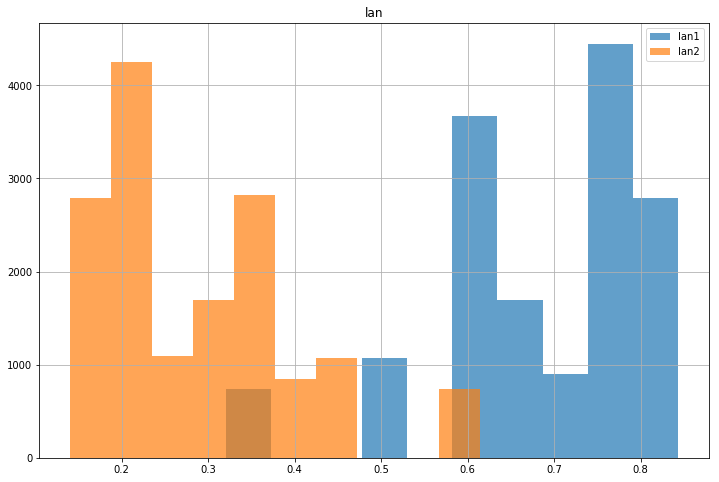

In [15]:
fig=plt.figure(figsize=(12,8))
plt.title("lan")
df['lan1'].hist(alpha=0.7,label='lan1')
df['lan2'].hist(alpha=0.7,label='lan2')
plt.legend(loc="upper right")

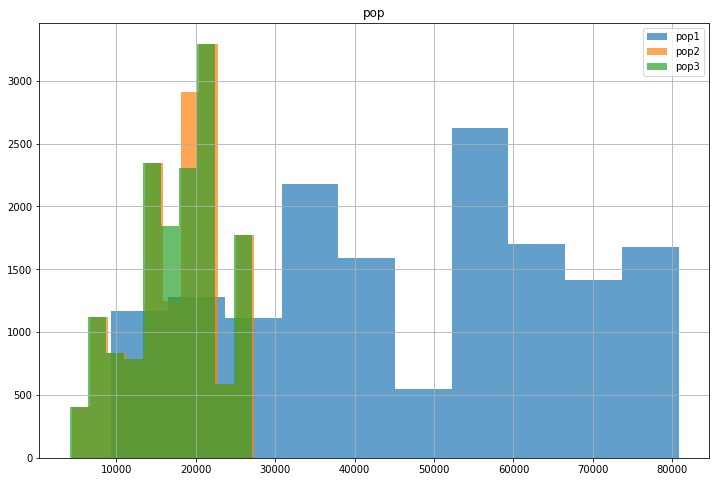

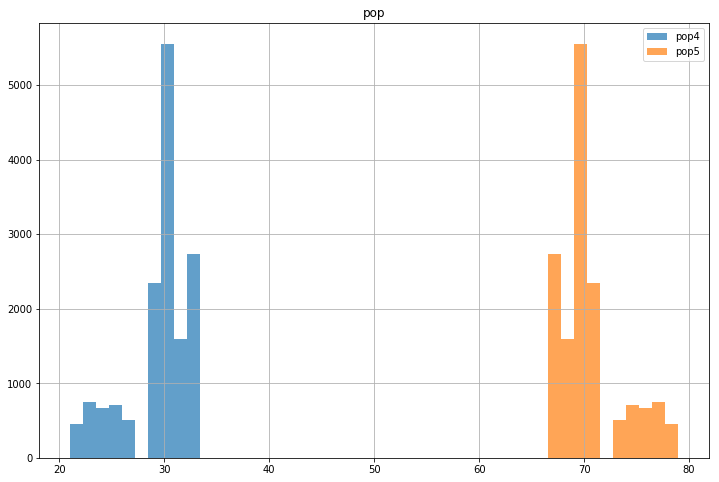

In [16]:
fig=plt.figure(figsize=(12,8))
plt.title("pop")
df['pop1'].hist(alpha=0.7,label='pop1')
df['pop2'].hist(alpha=0.7,label='pop2')
df['pop3'].hist(alpha=0.7,label='pop3')
plt.legend(loc="upper right")

fig=plt.figure(figsize=(12,8))
plt.title("pop")
df['pop4'].hist(alpha=0.7,label='pop4')
df['pop5'].hist(alpha=0.7,label='pop5')
plt.legend(loc="upper right")

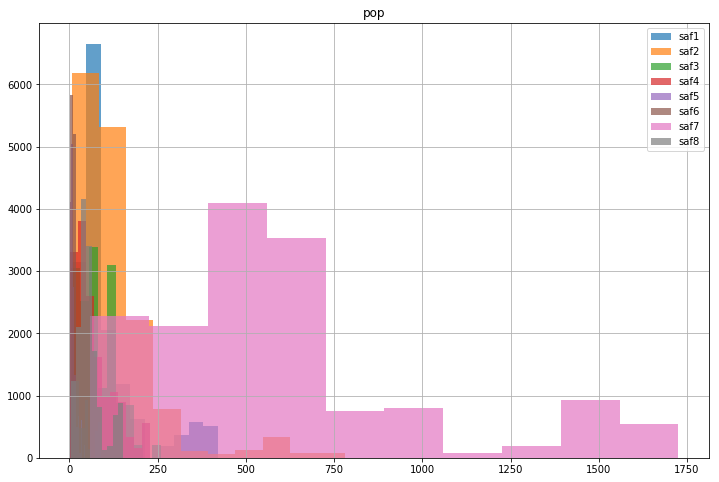

In [17]:
fig=plt.figure(figsize=(12,8))
plt.title("pop")
df['saf1'].hist(alpha=0.7,label='saf1')
df['saf2'].hist(alpha=0.7,label='saf2')
df['saf3'].hist(alpha=0.7,label='saf3')
df['saf4'].hist(alpha=0.7,label='saf4')
df['saf5'].hist(alpha=0.7,label='saf5')
df['saf6'].hist(alpha=0.7,label='saf6')
df['saf7'].hist(alpha=0.7,label='saf7')
df['saf8'].hist(alpha=0.7,label='saf8')

plt.legend(loc="upper right")


In [18]:
c=DecisionTreeClassifier(min_samples_split=1000)

In [19]:
features=["Year","YEAR_OF_CONSTRUCTION","saf1","saf2","saf3","saf4","saf5","saf6","saf7","saf8","mr5y","Inflation","pop1","pop2","pop3","pop4","pop5","pop6","lan1","lan2","inc1","inc2","inc3","inc4","own1","own2","own3","own4","lab1","lab2","lab3"]

In [20]:
X_train=train[features]
pd.cut(train['pct_change'], bins=10).value_counts()

#y_train=np.sign(train["pct_change"])
y_train=train['y_bin']
X_test=test[features]
#y_test=np.sign(test["pct_change"])
y_test=test['y_bin']


In [21]:
dt=c.fit(X_train, y_train)

In [22]:
def show_tree(tree, features, path):
    f=io.StringIO()
    export_graphviz(tree, out_file=f, feature_names=features)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    img=misc.imread(path)
    plt.rcParams["figure.figsize"]=(20,20)
    plt.imshow(img)

/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


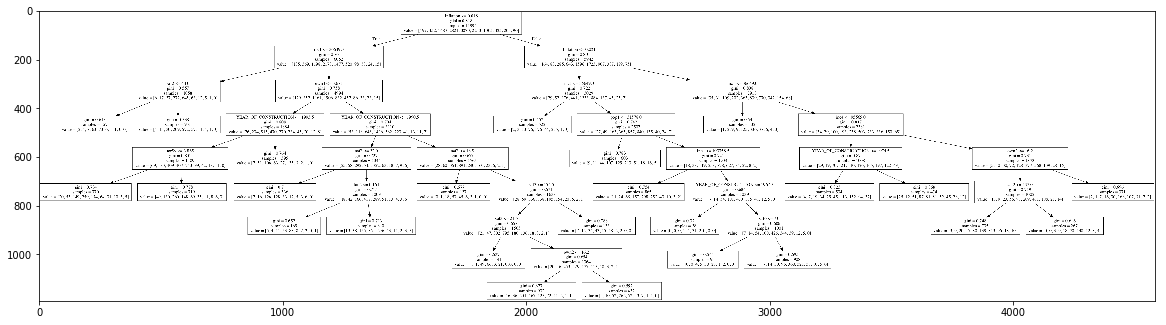

In [23]:
show_tree(dt,features,"dec_tree_02.png")

In [24]:
y_pred=c.predict(X_test)

In [25]:
y_pred

array([3, 3, 3, ..., 4, 4, 5])

In [26]:
from sklearn.metrics import accuracy_score
score=accuracy_score(y_test,y_pred)*100
print("Accuracy using Decision Tree:", round(score, 1),"%")

Accuracy using Decision Tree: 43.6 %


In [27]:
from sklearn.ensemble import RandomForestClassifier

model_rf=RandomForestClassifier(n_estimators=800)
model_rf.fit(X_train,y_train)
model_rf.score(X_test,y_test)

0.4514838279426476

Text(69.0, 0.5, 'Truth')

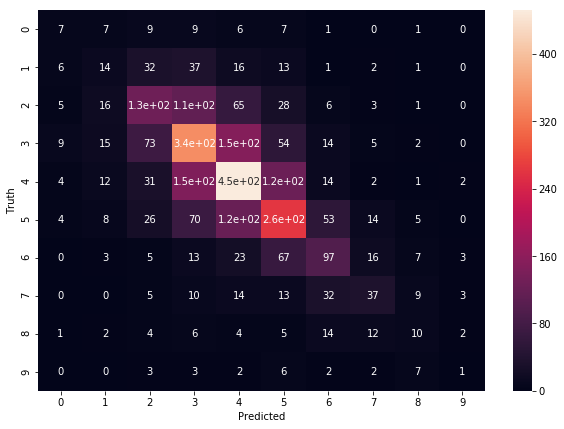

In [28]:
y_pred_rf=model_rf.predict(X_test)

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred_rf)
#cm=confusion_matrix(y_test,y_pred)
%matplotlib inline
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [29]:
y_test.value_counts()

4    789
3    668
5    564
2    366
6    234
7    123
1    122
8     60
0     47
9     26
Name: y_bin, dtype: int64

In [30]:
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
scaler=StandardScaler()
scaler.fit(df[features])
scaled_data=scaler.transform(df[features])
scaled_data

array([[-1.32153984e+00,  9.70805500e-01,  1.79787003e+00, ...,
         2.74460865e-03,  1.90514983e-01,  4.77460551e-01],
       [-4.26373010e-01,  9.70805500e-01,  2.05590205e+00, ...,
         2.74460865e-03,  1.90514983e-01,  4.77460551e-01],
       [ 4.68793819e-01,  9.70805500e-01,  2.33457662e+00, ...,
         2.74460865e-03,  1.90514983e-01,  4.77460551e-01],
       ...,
       [-4.26373010e-01,  1.07926157e+00, -7.30843666e-01, ...,
         2.84815636e+00, -2.22839413e+00, -2.61686218e+00],
       [ 4.68793819e-01,  1.07926157e+00, -5.55381899e-01, ...,
         2.84815636e+00, -2.22839413e+00, -2.61686218e+00],
       [ 1.36396065e+00,  1.07926157e+00, -8.85662872e-01, ...,
         2.84815636e+00, -2.22839413e+00, -2.61686218e+00]])

In [31]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pca.fit(scaled_data)

PCA(n_components=2)

In [32]:
x_pca=pca.transform(scaled_data)

In [33]:
x_pca

array([[ 7.56699359,  0.9070538 ],
       [ 8.37546503,  1.67505101],
       [ 8.08264414,  1.49180291],
       ...,
       [-3.14241942, -1.85230003],
       [-3.07919303, -1.70970686],
       [-3.96369286, -2.35090412]])

Text(0, 0.5, 'Second principle component')

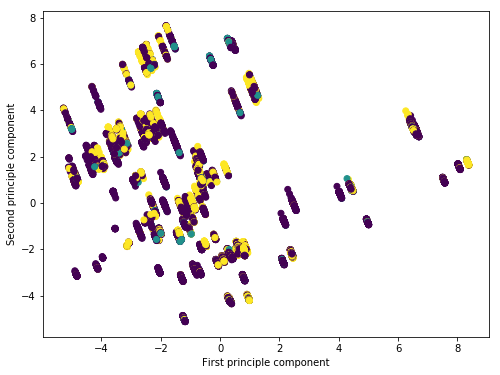

In [34]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=np.sign(df['pct_change']))
plt.xlabel('First principle component')
plt.ylabel('Second principle component')

In [35]:
#np.sign(df['pct_change']).unique()

Text(0, 0.5, 'cumulative explained variance')

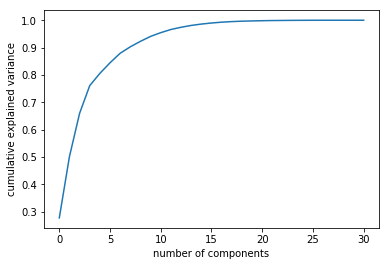

In [36]:
pca = PCA().fit(scaled_data)
ratio=np.cumsum(pca.explained_variance_ratio_)
plt.plot(ratio)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [37]:
ratio

array([0.27691   , 0.50113353, 0.65941345, 0.76082014, 0.80565153,
       0.84439123, 0.87922182, 0.90286136, 0.92288139, 0.94091273,
       0.95458806, 0.9661401 , 0.97426273, 0.98101497, 0.98599346,
       0.98988024, 0.99294462, 0.99503541, 0.9965701 , 0.99751023,
       0.99828585, 0.99889796, 0.99924571, 0.99954476, 0.99979366,
       0.99993452, 0.99998518, 0.9999932 , 0.99999637, 0.99999851,
       1.        ])

In [38]:
cat_feats=list(train.select_dtypes(include='object').columns)
cat_feats_num=['LATITUDE','LONGITUDE','ROLL_NUMBER','Year','y_bin']
cat_feats=cat_feats+cat_feats_num
num_feats=list(set(train.columns)-set(cat_feats)-set(['ASSESSED_VALUE']))
print('Numerical Features:', len(num_feats))
for feat in num_feats:
    print(feat, end=',')

Numerical Features: 31
saf1,lab1,saf7,lab2,lab3,own2,lan2,saf4,saf2,pop4,YEAR_OF_CONSTRUCTION,pop2,saf6,inc4,saf5,inc3,Inflation,pop5,mr5y,own3,pop1,lan1,inc2,saf3,own1,pop3,pct_change,saf8,own4,pop6,inc1,

In [39]:
print('Categorical Features:', len(cat_feats))
for feat in cat_feats:
    print(feat, end=',')

Categorical Features: 10
ADDRESS,COMM_CODE,COMM_NAME,location,fsa,LATITUDE,LONGITUDE,ROLL_NUMBER,Year,y_bin,

In [40]:
train.isnull().sum().sort_values(ascending=False)

y_bin                   0
pct_change              0
saf7                    0
saf6                    0
saf5                    0
saf4                    0
saf3                    0
saf2                    0
saf1                    0
YEAR_OF_CONSTRUCTION    0
fsa                     0
lab3                    0
location                0
Year                    0
ROLL_NUMBER             0
LONGITUDE               0
LATITUDE                0
COMM_NAME               0
COMM_CODE               0
ASSESSED_VALUE          0
saf8                    0
mr5y                    0
Inflation               0
pop1                    0
lab2                    0
lab1                    0
own4                    0
own3                    0
own2                    0
own1                    0
inc4                    0
inc3                    0
inc2                    0
inc1                    0
lan2                    0
lan1                    0
pop6                    0
pop5                    0
pop4        

In [41]:
test.isnull().sum().sort_values(ascending=False)

y_bin                   0
pct_change              0
saf7                    0
saf6                    0
saf5                    0
saf4                    0
saf3                    0
saf2                    0
saf1                    0
YEAR_OF_CONSTRUCTION    0
fsa                     0
lab3                    0
location                0
Year                    0
ROLL_NUMBER             0
LONGITUDE               0
LATITUDE                0
COMM_NAME               0
COMM_CODE               0
ASSESSED_VALUE          0
saf8                    0
mr5y                    0
Inflation               0
pop1                    0
lab2                    0
lab1                    0
own4                    0
own3                    0
own2                    0
own1                    0
inc4                    0
inc3                    0
inc2                    0
inc1                    0
lan2                    0
lan1                    0
pop6                    0
pop5                    0
pop4        

In [42]:
def bar_plot(variable):
    var=train[variable]
    varValue=var.value_counts()
    
    plt.figure(figsize=(9,3))
    plt.bar(varValue.index, varValue)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("Frequency")
    plt.title(variable)
    plt.show()
    print("{}\n{}".format(variable, varValue))

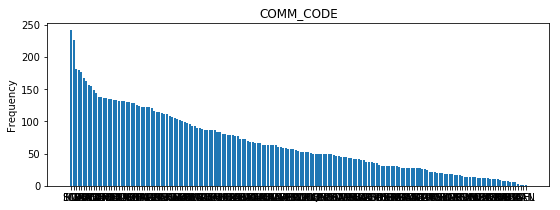

COMM_CODE
SIG    241
EDG    227
MRT    182
COV    179
VAR    177
      ... 
RUT      6
MAF      3
SGH      2
MAN      2
BEL      2
Name: COMM_CODE, Length: 181, dtype: int64


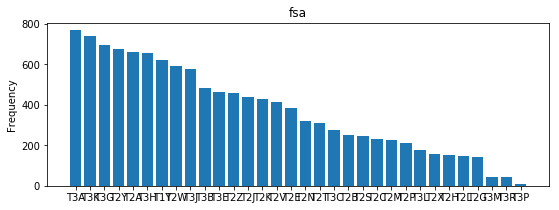

fsa
T3A    767
T3K    742
T3G    696
T2Y    674
T2A    660
T3H    658
T1Y    622
T2W    590
T3J    577
T3B    481
T3E    461
T2Z    459
T2J    437
T2K    431
T2V    412
T2E    386
T2N    319
T2T    311
T3C    276
T2B    253
T2S    247
T2C    232
T2M    226
T2P    211
T3L    175
T2X    156
T2H    154
T2L    146
T2G    140
T3M     43
T3R     42
T3P     10
Name: fsa, dtype: int64


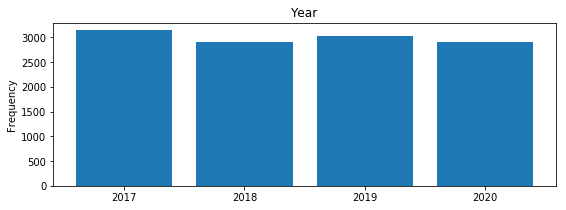

Year
2017    3141
2019    3029
2018    2913
2020    2911
Name: Year, dtype: int64


In [43]:
for i in ['COMM_CODE','fsa','Year']:
    bar_plot(i)
    

In [44]:
categorical=['COMM_CODE','fsa','Year']

for i in range(0,3):
    print(train[[categorical[i], "pct_change"]].groupby([categorical[i]], as_index=False).mean().sort_values(by="pct_change", ascending=False))

    COMM_CODE  pct_change
143       SGH    0.027573
44        DIA    0.013233
123       RAM    0.005516
21        CAP    0.004710
103       MPL    0.003453
..        ...         ...
46        DNC   -0.042354
48        DNW   -0.044412
8         BEL   -0.046483
59        EVN   -0.046920
90        MAF   -0.056258

[181 rows x 2 columns]
    fsa  pct_change
7   T2J   -0.003014
10  T2M   -0.004101
9   T2L   -0.006308
29  T3M   -0.011865
26  T3J   -0.012348
31  T3R   -0.014274
2   T2B   -0.015216
24  T3G   -0.015688
20  T3A   -0.015886
3   T2C   -0.015980
21  T3B   -0.016960
8   T2K   -0.017940
0   T1Y   -0.018252
11  T2N   -0.018732
5   T2G   -0.019002
1   T2A   -0.019104
25  T3H   -0.019428
27  T3K   -0.020787
19  T2Z   -0.020870
18  T2Y   -0.022412
4   T2E   -0.022433
16  T2W   -0.022551
15  T2V   -0.022671
6   T2H   -0.023156
14  T2T   -0.023512
22  T3C   -0.025057
17  T2X   -0.027162
23  T3E   -0.028406
13  T2S   -0.031521
12  T2P   -0.037172
28  T3L   -0.037585
30  T3P   -0.046920
   Y

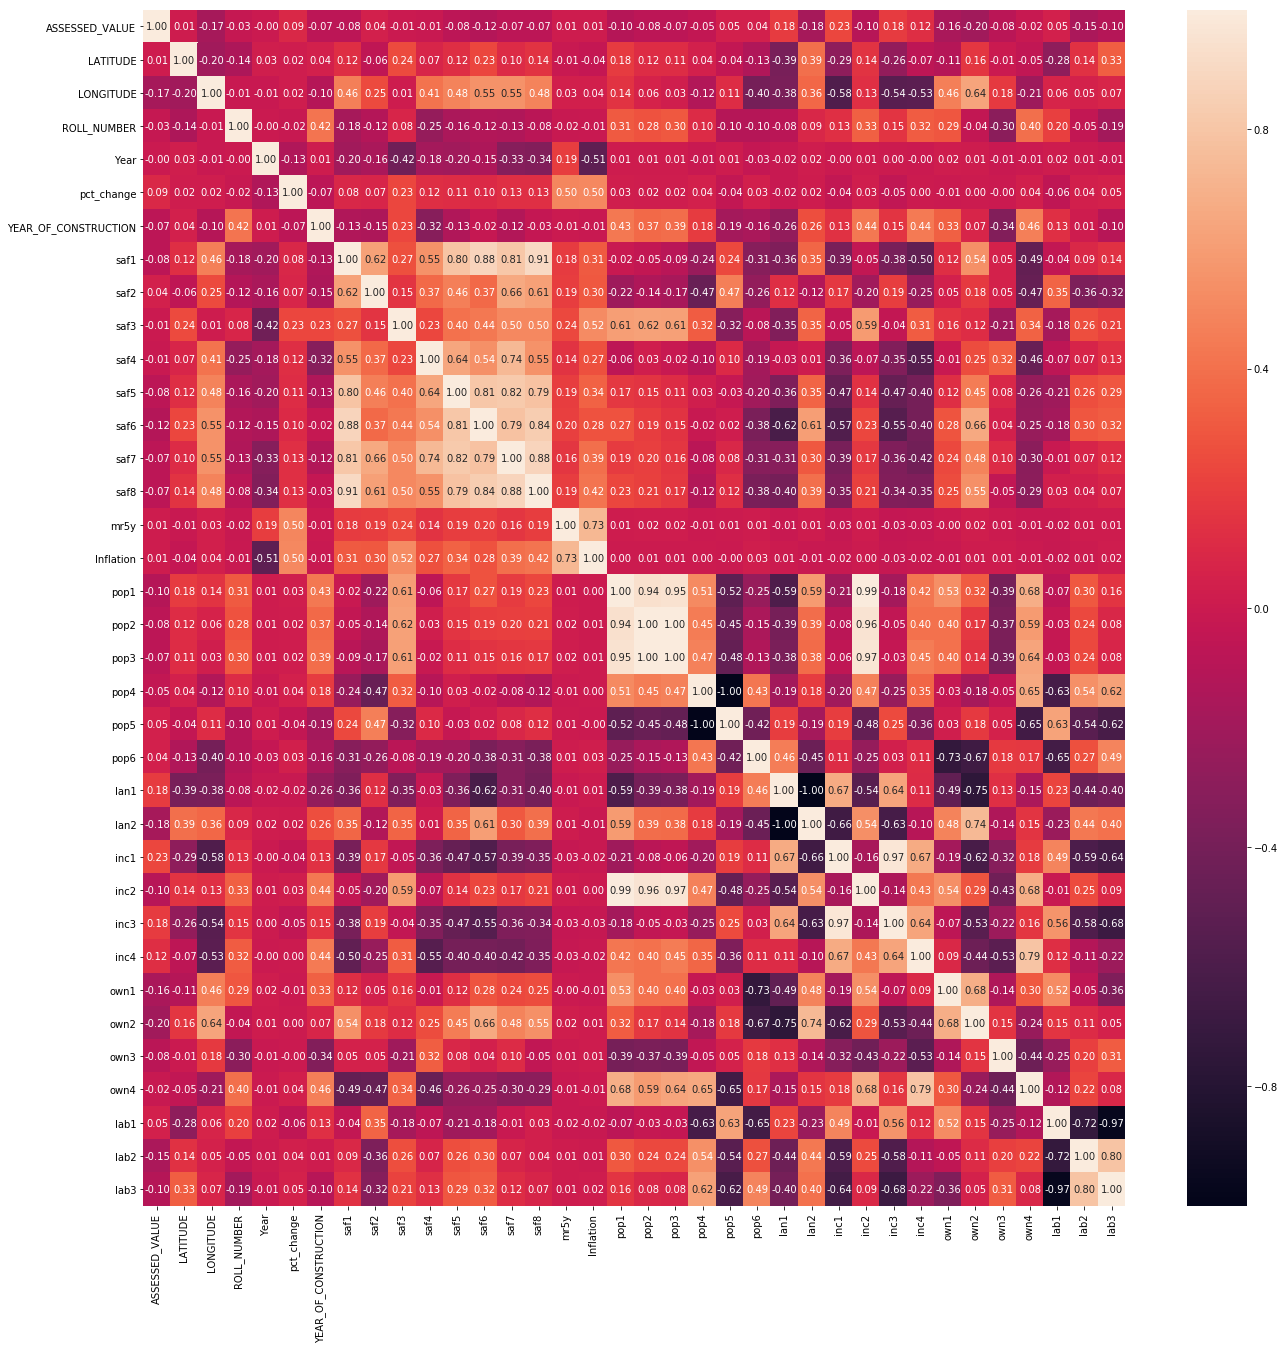

In [45]:
#train.corr()
f,ax=plt.subplots(figsize=(22,22))
sns.heatmap(train.corr(), vmax=1, vmin=-1, annot=True, fmt=".2f")
plt.show()

In [93]:
from sklearn import preprocessing
x=train[num_feats].values
min_max_scaler=preprocessing.MinMaxScaler()
x_scaled=min_max_scaler.fit_transform(x)


#standard_scaler=preprocessing.StandardScaler()
#x_scaled=standard_scaler.fit_transform(x)


data_regression=pd.DataFrame(x_scaled,columns=train[num_feats].columns)

#data_regression=train[num_feats]
X_r=data_regression.drop('pct_change',axis=1).values
y_r=data_regression['pct_change'].values
names=data_regression.drop('pct_change',axis=1).columns

In [94]:
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=0.00001,normalize=True)
lasso_coef=lasso.fit(X_r,y_r).coef_

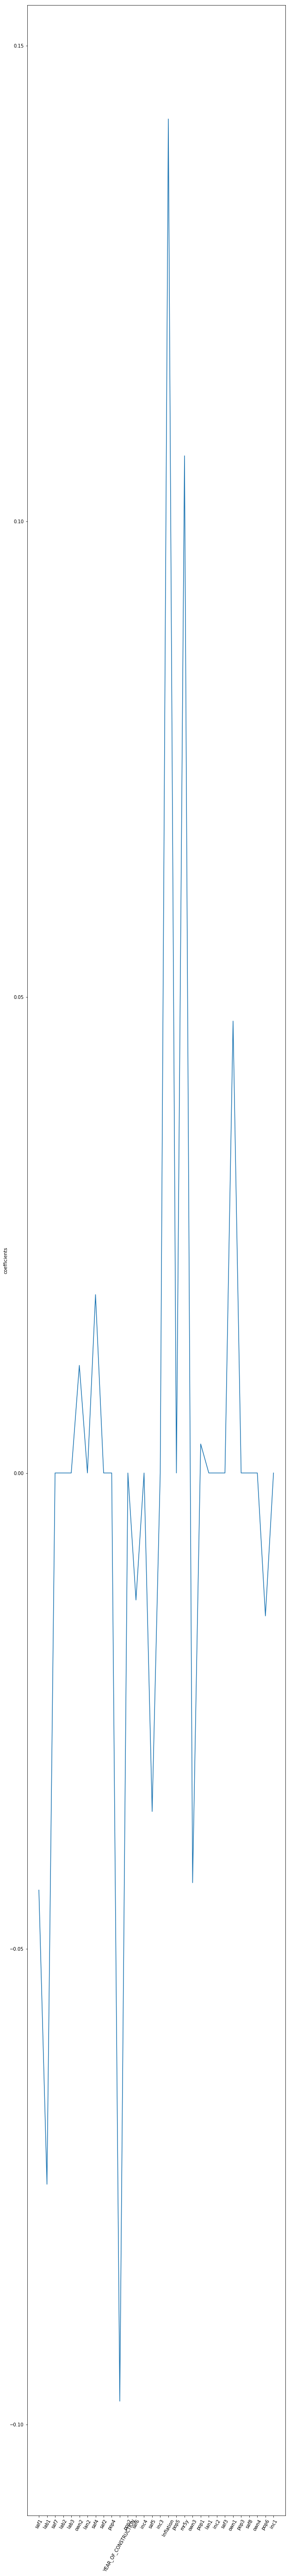

In [95]:
_=plt.plot(range(len(names)),lasso_coef)
_=plt.xticks(range(len(names)),names,rotation=60)
_=plt.ylabel("coefficients")
plt.show()

In [49]:
from sklearn.linear_model import LinearRegression
L=LinearRegression()
L.fit(X_r,y_r)



data_test_r=test[num_feats]
X_r_t=data_test_r.drop('pct_change',axis=1).values
y_r_t=data_test_r['pct_change'].values

y_pred_r=L.predict(X_r_t)

from sklearn.metrics import r2_score, mean_squared_error

print('R2 score', r2_score(y_r_t,y_pred_r))
print('RMSE',np.sqrt(mean_squared_error(y_r_t,y_pred_r)))

R2 score 0.33877789325431373
RMSE 0.03590909250661316


0.03547546767755862

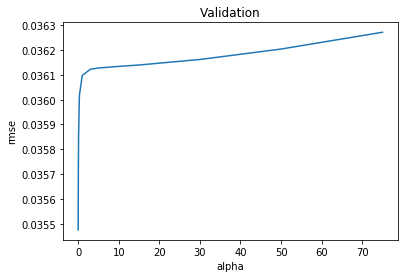

In [50]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV

from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_r, y_r, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)
R=Ridge()
alphas = [0.00001,0.001,0.01,0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

cv_ridge.min()

In [51]:
#model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_r, y_r)
model_lasso = LassoCV(alphas = [0.1]).fit(X_r, y_r)
rmse_cv(model_lasso).mean()

/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5149381101050565, tolerance: 0.0018096534054847
  tol, rng, random, positive)
/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.903609651398199, tolerance: 0.001768411049135564
  tol, rng, random, positive)
/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6006581608412356, tolerance: 0.0017970108055213204
  tol, rng, random, positive)
/Users/DongyingWang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_de

0.04122074438576669

In [52]:
coef = pd.Series(model_lasso.coef_, index = names)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 11 variables and eliminated the other 19 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

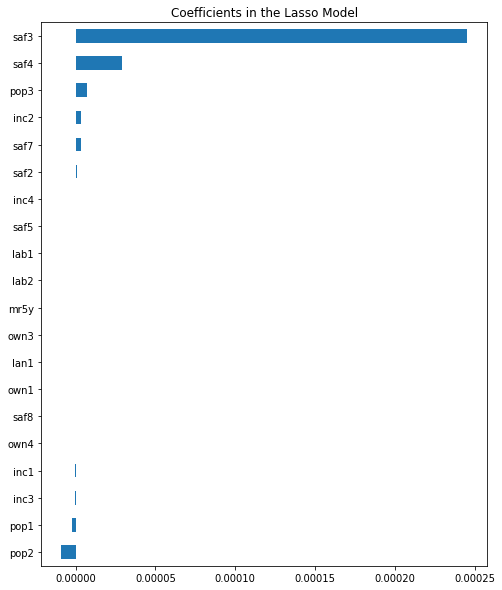

In [53]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [54]:
#model_lasso.coef_

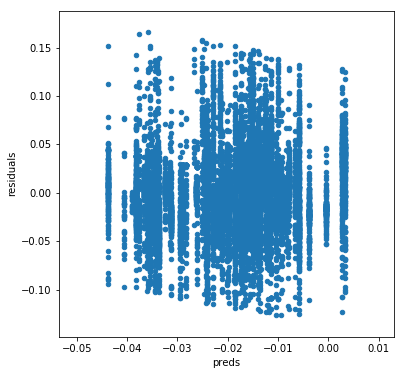

In [55]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_r), "true":y_r})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")




In [56]:
pred2 = model_lasso.predict(X_r_t)           
print(mean_squared_error(y_r_t, pred2))    

0.0017900045114882745


Ridge picked 30 variables and eliminated the other 0 variables


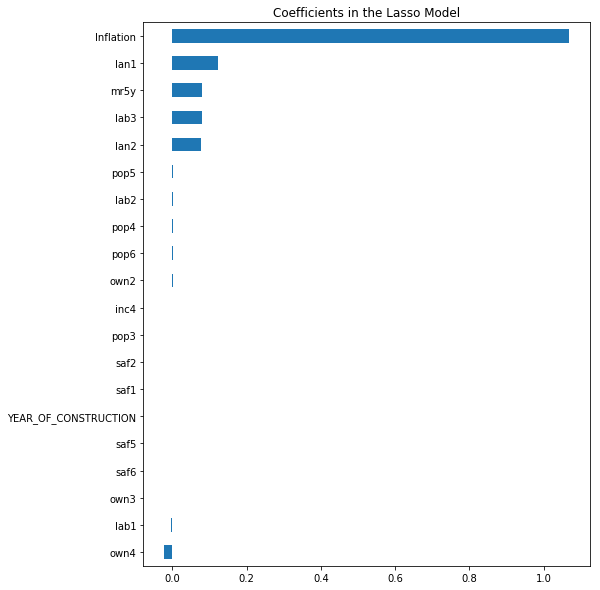

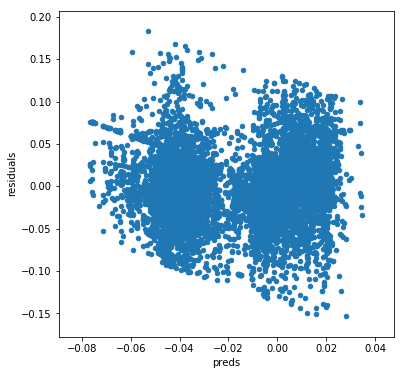

In [57]:
#model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_r, y_r)
model_ridge = RidgeCV(alphas = [0.1]).fit(X_r, y_r)
rmse_cv(model_ridge).mean()
coef = pd.Series(model_ridge.coef_, index = names)
print("Ridge picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_ridge.predict(X_r), "true":y_r})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [58]:
pred3 = model_ridge.predict(X_r_t)           
print(mean_squared_error(y_r_t, pred3))    

0.001311859266151784


In [59]:
df['y_bin']=pd.cut(df['pct_change'], bins=np.linspace(df['pct_change'].quantile(0.01), df['pct_change'].quantile(0.99), 5),labels=range(0,4))
df_tree=df.dropna()

In [60]:
np.linspace(df['pct_change'].quantile(0.01), df['pct_change'].quantile(0.99), 5)

array([-0.13808762, -0.07033383, -0.00258004,  0.06517375,  0.13292754])

In [61]:


df_boost=df_tree.drop(['ADDRESS','ASSESSED_VALUE','COMM_NAME','LATITUDE','LONGITUDE','ROLL_NUMBER','Year','location','pct_change','y_bin'],axis=1)






In [62]:
df_boost.keys()

Index(['COMM_CODE', 'fsa', 'YEAR_OF_CONSTRUCTION', 'saf1', 'saf2', 'saf3',
       'saf4', 'saf5', 'saf6', 'saf7', 'saf8', 'mr5y', 'Inflation', 'pop1',
       'pop2', 'pop3', 'pop4', 'pop5', 'pop6', 'lan1', 'lan2', 'inc1', 'inc2',
       'inc3', 'inc4', 'own1', 'own2', 'own3', 'own4', 'lab1', 'lab2', 'lab3'],
      dtype='object')

In [63]:
#y_boost=np.sign(df['pct_change'])
y_boost=df_tree['y_bin']

In [64]:
#df_boost.dtypes

In [65]:
#y_boost

In [66]:
df_encoded=pd.get_dummies(df_boost,columns=['COMM_CODE','fsa'])

In [67]:
x_train, x_test, y_train, y_test=train_test_split(df_encoded,y_boost,test_size=0.2)

In [68]:
#clf_xgb=xgb.XGBClassifier(objective='reg:linear', seed=42)
#clf_xgb.fit(x_train,y_train,verbose=True,early_stopping_rounds=10,eval_metric='aucpr',eval_set=[(x_test,y_test)])

In [69]:
#classifier=xgb.XGBRegressor()
#classifier=xgb.XGBClassifier()
#classifier.fit(x_train,y_train)
#booster=['gbtree','gblinear']
#base_score=[0.25,0.5,0.75,1]

In [70]:
from sklearn.ensemble import GradientBoostingClassifier

GB_classifier=GradientBoostingClassifier()
GB_classifier.fit(x_train,y_train)






GradientBoostingClassifier()

In [71]:
y_pred_g=GB_classifier.predict(x_test)

In [72]:
print("Accuracy of Model:",accuracy_score(y_test,y_pred_g))


Accuracy of Model: 0.7045681893964655


In [73]:
xgb_classifier=xgb.XGBClassifier(objective='multi:softprob')
xgb_classifier.fit(x_train,y_train)
y_pred_x=xgb_classifier.predict(x_test)
print("Accuracy of Model:",accuracy_score(y_test,y_pred_x))


Accuracy of Model: 0.695565188396132


In [74]:
#x_train.dtypes

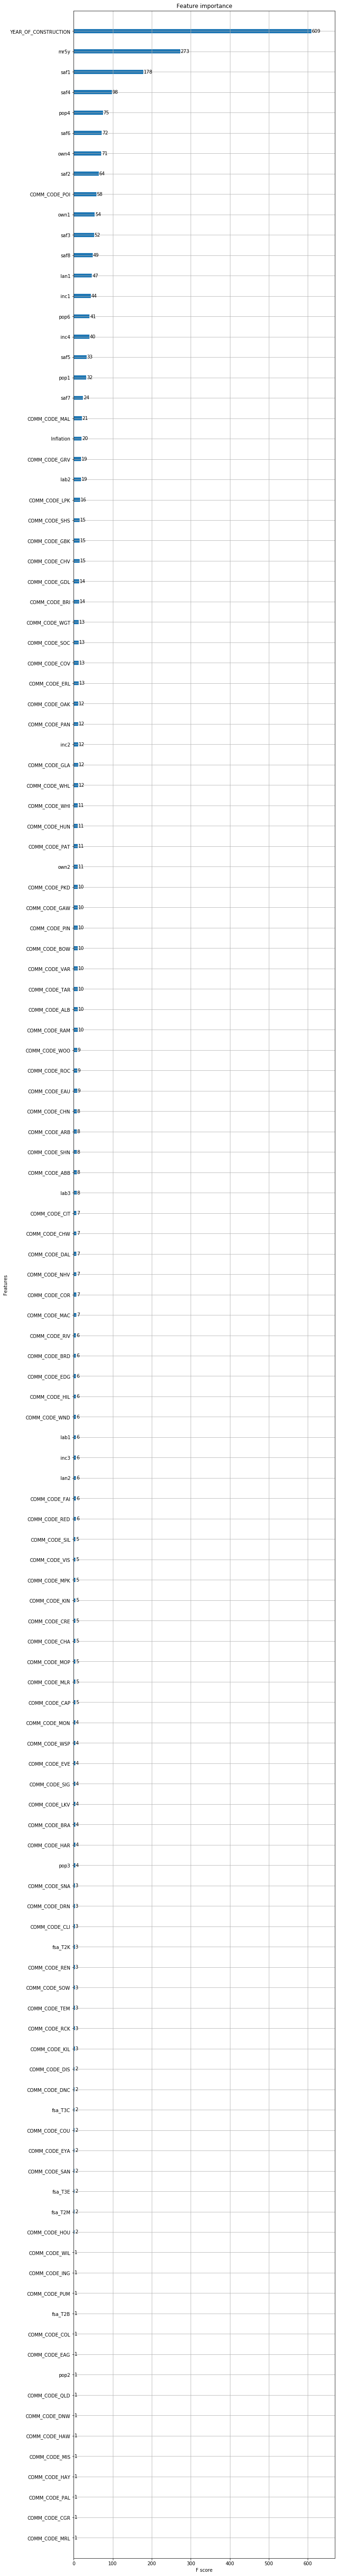

In [82]:
xgb.plot_importance(xgb_classifier)

#plt.rcParams['figure.figsize']=[1000,10]
plt.rcParams['figure.figsize'] = (10.0, 100.0)
plt.show()

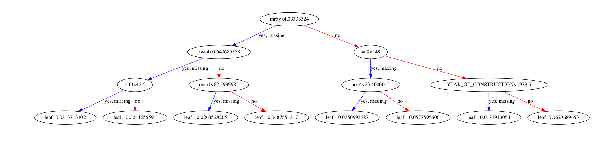

In [76]:
xgb.plot_tree(xgb_classifier,num_trees=0)
plt.rcParams['figure.figsize']=[10,50]
plt.show()

In [77]:
#data_dmatrix=xgb.DMatrix(data=x_train,label=y_train)
#params={'max_depth':2,'eta':1,'silent':1,'objective':'multi:softprob'}
#xgb_clf=xgb.train(params=params,dtrain=data_dmatrix,num_boost_round=10)

In [78]:
#xgb.plot_tree(xgb_clf,num_trees=0)
#plt.rcParams['figure.figsize']=[100,50]
#plt.show()

In [79]:
xgb_classifier

XGBClassifier(objective='multi:softprob')

Text(69.0, 0.5, 'Truth')

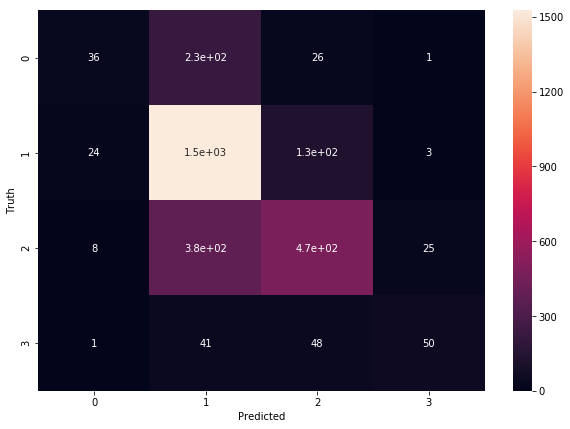

In [80]:
cm=confusion_matrix(y_test,y_pred_x)
#cm=confusion_matrix(y_test,y_pred)
%matplotlib inline
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")